# Bank Marketing Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import datasets
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
%matplotlib inline
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as PImage

In [18]:
# Load data file
bank=pd.read_csv('data/bank/bank-full.csv', sep=';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Summary of data

### Categorical Variables :
**[1] job      :** admin,technician, services, management, retired, blue-collar, unemployed, entrepreneur,
               housemaid, unknown, self-employed, student
<br>**[2] marital  :** married, single, divorced
<br>**[3] education:** secondary, tertiary, primary, unknown
<br>**[4] default  :** yes, no
<br>**[5] housing  :** yes, no
<br>**[6] loan     :** yes, no 
<br>**[7] deposit  :** yes, no ** (Dependent Variable)**
<br>**[8] contact  :** unknown, cellular, telephone
<br>**[9] month    :** jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec
<br>**[10] poutcome:** unknown, other, failure, success

### Numerical Variables:
**[1] age
<br>[2] balance
<br>[3] day
<br>[4] duration
<br>[5] campaign
<br>[6] pdays
<br>[7] previous**

### Treat categorical data

In [19]:
# Make a copy for parsing
bank_data = bank.copy()

####  poutcome 

In [20]:
# Combine 'unknown' and 'other'
bank_data['poutcome'] = bank_data['poutcome'].replace(['unknown'] , 'other')
bank_data.poutcome.value_counts()

other      38799
failure     4901
success     1511
Name: poutcome, dtype: int64

In [21]:
# Drop 'contact', as every participant has been contacted. 
bank_data.drop('contact', axis=1, inplace=True)

####  replace to booleans 

In [22]:
# values for "default" : yes/no
bank_data["default"]
bank_data['default_cat'] = bank_data['default'].map( {'yes':1, 'no':0} )
bank_data.drop('default', axis=1,inplace = True)

# values for "housing" : yes/no
bank_data["housing_cat"]=bank_data['housing'].map({'yes':1, 'no':0})
bank_data.drop('housing', axis=1,inplace = True)

# values for "loan" : yes/no
bank_data["loan_cat"] = bank_data['loan'].map({'yes':1, 'no':0})
bank_data.drop('loan', axis=1, inplace=True)

#### month, day

In [23]:
# Drop 'month' and 'day' as they don't have any intrinsic meaning
bank_data.drop('month', axis=1, inplace=True)
bank_data.drop('day', axis=1, inplace=True)

#### y

In [24]:
# values for "y" : yes/no
bank_data["deposit"] = bank_data['y'].map({'yes':1, 'no':0})
bank_data.drop('y', axis=1, inplace=True)

In [25]:
bank_data["deposit"]

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: deposit, Length: 45211, dtype: int64

### Convert categorical data

In [27]:
bank_data.head()

,age,job,marital,education,balance,duration,campaign,pdays,previous,poutcome,default_cat,housing_cat,loan_cat,deposit
0,58,management,married,tertiary,2143,261,1,-1,0,other,0,1,0,0
1,44,technician,single,secondary,29,151,1,-1,0,other,0,1,0,0
2,33,entrepreneur,married,secondary,2,76,1,-1,0,other,0,1,1,0
3,47,blue-collar,married,unknown,1506,92,1,-1,0,other,0,1,0,0
4,33,unknown,single,unknown,1,198,1,-1,0,other,0,0,0,0


In [29]:
# Use pandas dummy to convert categorical data
bank_with_dummies = pd.get_dummies(data=bank_data, columns = ['job', 'marital', 'education', 'poutcome'], prefix = ['job', 'marital', 'education', 'poutcome'])
bank_with_dummies.head()

,age,balance,duration,campaign,pdays,previous,default_cat,housing_cat,loan_cat,deposit,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success
0,58,2143,261,1,-1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1,44,29,151,1,-1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,33,2,76,1,-1,0,0,1,1,0,...,0,1,0,0,1,0,0,0,1,0
3,47,1506,92,1,-1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
4,33,1,198,1,-1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0


In [30]:
bank_with_dummies.describe()

,age,balance,duration,campaign,pdays,previous,default_cat,housing_cat,loan_cat,deposit,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,...,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841,40.197828,0.580323,0.018027,0.555838,0.160226,0.116985,...,0.115171,0.601933,0.282896,0.151534,0.513194,0.294198,0.041074,0.108403,0.858176,0.033421
std,10.618762,3044.765829,257.527812,3.098021,100.128746,2.303441,0.133049,0.496878,0.366820,0.321406,...,0.319232,0.489505,0.450411,0.358572,0.499831,0.455687,0.198464,0.310892,0.348873,0.179735
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Classification

In [33]:
# Train-Test split: 20% test data
bankcl = bank_with_dummies
data_drop_deposite = bankcl.drop('deposit', 1)
label = bankcl.deposit
data_train, data_test, label_train, label_test = train_test_split(data_drop_deposite, label, test_size = 0.2, random_state = 50)

In [49]:
max_depth = 6
criterions = ['gini', 'entropy']
splitter = ['random', 'best']
best_score = 0

In [59]:
for c in criterions:
    for s in splitter:
        i=2
        while i<max_depth:
            i+=1
            dt = tree.DecisionTreeClassifier(random_state=1, max_depth=i, criterion=c, splitter=s)
            dt.fit(data_train, label_train)
            dt_score_train = dt.score(data_train, label_train)
            #print("Training score: ",dt_score_train)
            dt_score_test = dt.score(data_test, label_test)
            #print("Testing score: ",dt_score_test)
            if dt_score_test > best_score:
                best_score = dt_score_test
                best_config = {'criterion': c, 'splitter': s, 'depth': i, 'test_score': dt_score_test, 'train_score': dt_score_train}
                best_dt = dt

In [113]:
print("Best score: ", best_score)
print("Using config: ", best_config)
dt = best_dt

Best score:  0.9027977441114674
Using config:  {'criterion': 'entropy', 'splitter': 'best', 'depth': 4, 'test_score': 0.9027977441114674, 'train_score': 0.9009068790090687}


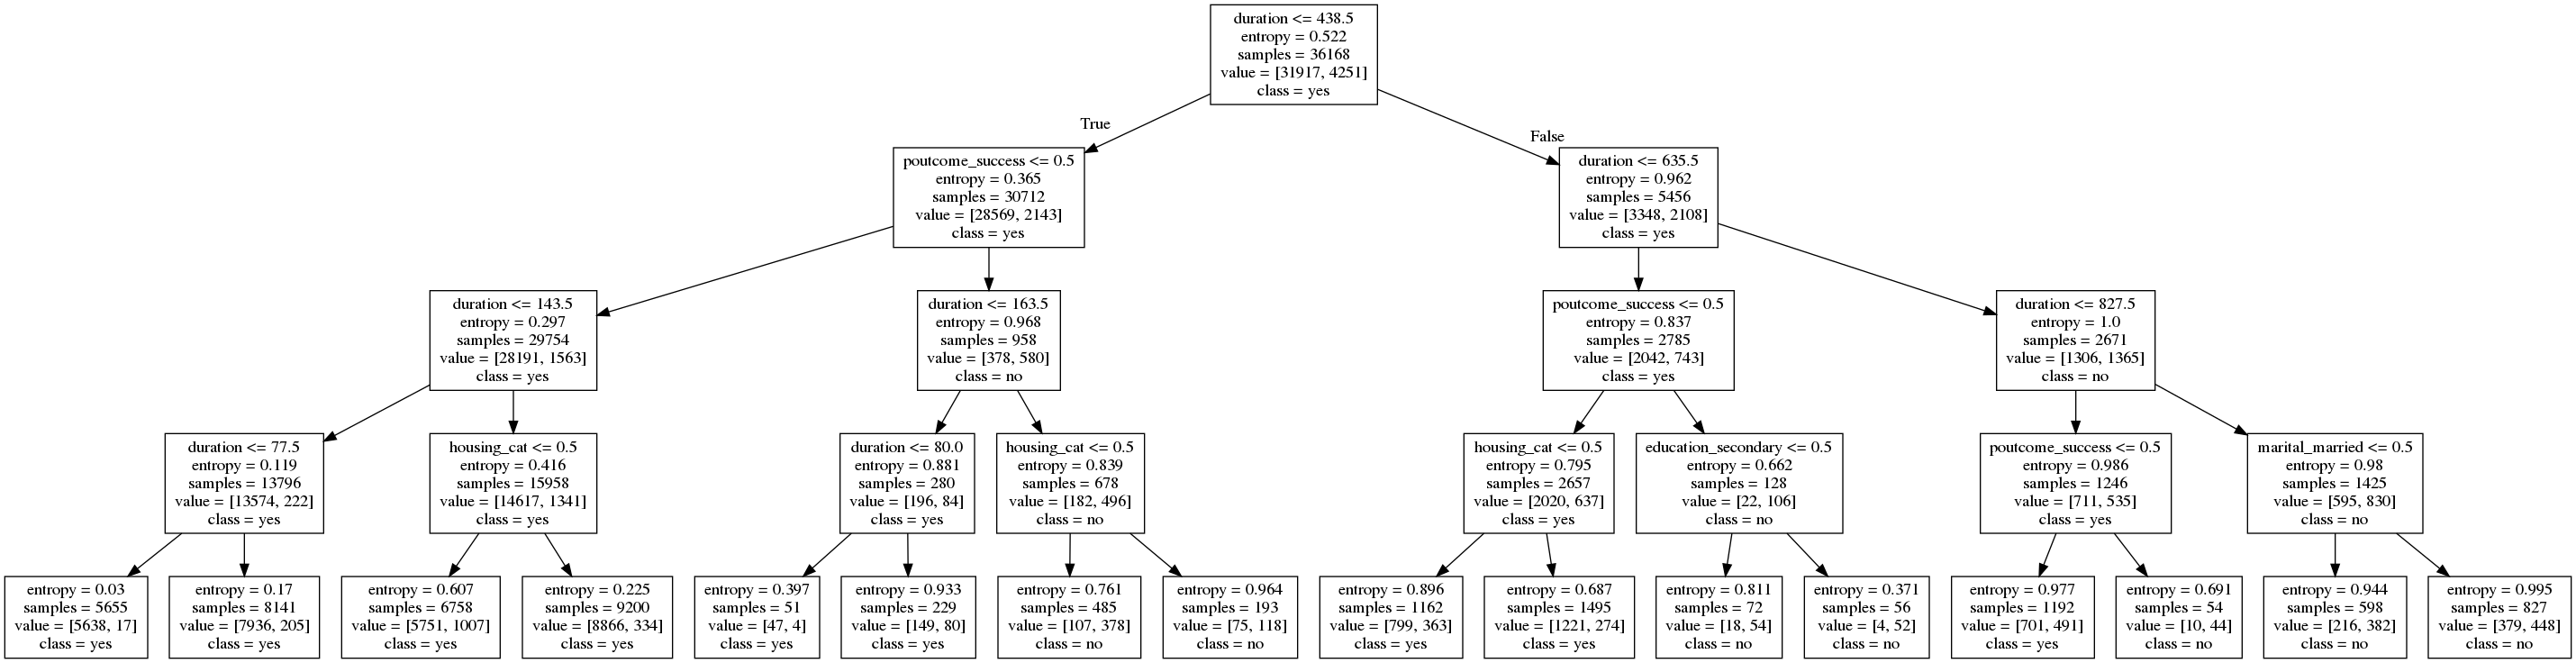

In [114]:
features = bankcl.drop('deposit', 1).columns.tolist()
tree.export_graphviz(dt, out_file='tree.dot', class_names=['yes','no'], feature_names=features)

check_call(['dot','-Tpng','tree.dot','-o','tree.png'])

# Annotating chart with PIL
img = Image.open("tree.png")
draw = ImageDraw.Draw(img)
img.save('tree.png')
PImage("tree.png")

## Questions

In [115]:
n_nodes = dt.tree_.node_count
children_left = dt.tree_.children_left
children_right = dt.tree_.children_right
feature = dt.tree_.feature
threshold = dt.tree_.threshold
values = dt.tree_.value

In [118]:
# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes "
      % n_nodes)



The binary tree structure has 31 nodes 


In [ ]:
i=0
while True:
    if is_leaves[i]:
        if values[i][0][0]>values[i][0][1]:
            result = "yes"
        else:
            result = "no"
        print("Result is: %s" % result)
        break
    answer = input("Is %s <= %s ? [y/n] " % (features[feature[i]], threshold[i]))
    #print(answer)
    if answer == 'y':
        i=children_left[i]
    else:
        i=children_right[i]

Is duration <= 438.5 ? [y/n] 300


In [112]:
i=0
answers = {}
while True:
    if is_leaves[i]:
        if values[i][0][0]>values[i][0][1]:
            result = "yes"
        else:
            result = "no"
        print("Result is: %s" % result)
        break
    if features[feature[i]] in answers:
        answer = answers[features[feature[i]]]
    else:
        answer = input("What is the value for %s: " % (features[feature[i]]))
        answers[features[feature[i]]] = answer
    #print(answer)
    if float(answer) <= float(threshold[i]):
        i=children_left[i]
    else:
        i=children_right[i]

What is the value for duration: 300
What is the value for poutcome_success: 0.7
What is the value for housing_cat: 0.3
What is the value for age: 25
Result is: no


In [103]:
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        if values[i][0][0]>values[i][0][1]:
            result = "yes"
        else:
            result = "no"
        print("%snode=%s test node: go to node %s if %s <= %s else to "
              "node %s class is %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 features[feature[i]],
                 threshold[i],
                 children_right[i],
                 result
                 ))
print()


node=0 test node: go to node 1 if duration <= 438.5 else to node 58 class is yes.
	node=1 test node: go to node 2 if poutcome_success <= 0.5 else to node 31 class is yes.
		node=2 test node: go to node 3 if duration <= 143.5 else to node 16 class is yes.
			node=3 test node: go to node 4 if duration <= 77.5 else to node 9 class is yes.
				node=4 test node: go to node 5 if campaign <= 4.5 else to node 8 class is yes.
					node=5 test node: go to node 6 if education_tertiary <= 0.5 else to node 7 class is yes.
						node=6 leaf node.
						node=7 leaf node.
					node=8 leaf node.
				node=9 test node: go to node 10 if housing_cat <= 0.5 else to node 13 class is yes.
					node=10 test node: go to node 11 if age <= 29.5 else to node 12 class is yes.
						node=11 leaf node.
						node=12 leaf node.
					node=13 test node: go to node 14 if job_blue-collar <= 0.5 else to node 15 class is yes.
						node=14 leaf node.
						node=15 leaf node.
			node=16 test node: go to node 17 if housing_ca

## Predictions

In [55]:
# According to feature importance results, most importtant feature is the "Duration"
# Let's calculte statistics on Duration
print("Mean duration   : ", data_drop_deposite.duration.mean())
print("Maximun duration: ", data_drop_deposite.duration.max())
print("Minimum duration: ", data_drop_deposite.duration.min())

Mean duration   :  263.96129174961294
Maximun duration:  3025
Minimum duration:  4


In [56]:
# Predict: Successful deposite with a call duration = 371 sec

print(dt2.predict_proba(np.array([0, 0, 371, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))
print(dt2.predict(np.array([0, 0, 371, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))
# column 0: probability for class 0 (not signed for term deposite) & column 1: probability for class 1
# Probability of Successful deposite = 0.51484432

[[0.34444444 0.65555556]]
[1]


In [57]:
# Predict: Successful deposite with a maximun call duration = 3881 sec

print(dt2.predict_proba(np.array([0, 0, 3881, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))
print(dt2.predict(np.array([0, 0, 3881, 0, 0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]).reshape(1, -1)))

[[0.41322314 0.58677686]]
[1]


In [58]:
# Get a row with poutcome_success = 1
#bank_with_dummies[(bank_with_dummies.poutcome_success == 1)]
data_drop_deposite.iloc[985]

age                     58.0000
balance                543.0000
duration               264.0000
campaign                 3.0000
previous                 0.0000
default_cat              0.0000
housing_cat              0.0000
loan_cat                 1.0000
recent_pdays             0.0001
job_blue-collar          1.0000
job_entrepreneur         0.0000
job_other                0.0000
job_pink-collar          0.0000
job_self-employed        0.0000
job_technician           0.0000
job_white-collar         0.0000
marital_divorced         1.0000
marital_married          0.0000
marital_single           0.0000
education_primary        0.0000
education_secondary      1.0000
education_tertiary       0.0000
education_unknown        0.0000
poutcome_failure         0.0000
poutcome_success         0.0000
poutcome_unknown         1.0000
Name: 985, dtype: float64

In [59]:
# Predict: Probability for above

print(dt2.predict_proba(np.array([46,3354,522,1,1,0,1,0,0.005747,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0]).reshape(1, -1)))
#print(ctree.predict(np.array([46,3354,522,1,1,0,1,0,0.005747,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0]).reshape(1, -1)))

[[0.34444444 0.65555556]]
